# Positional Encoding Demo
Adapted from Brown CSCI 1430 Neural Fields Spring 2022 2D image encoding demo

Based on Colab from here on Gaussian activations - thanks!
https://colab.research.google.com/drive/1F1c2ouulmqys-GJBVBHn04I1UVWeexiB

This demo illustrates the effect of positional encoding for neural networks which aim to learn high-frequency functions in low-dimensional domains. We define an optimization problem to reconstruct a 2D image. You can choose a type of positional encoding - raw pixel coordinates, sine and cosine, or random fourier features (RFF).

After training the network, if sincos or RFF positional encoding was used, the demo will create a visualization of the effect of the positional encoding. We generate this visualization by having the model predict on a version of the input that has values corresponding to frequency bands zeroed out. In the visualization, each frame represents a separate prediction by the model; the only difference is that earlier frames have more values of the input zeroed out, therefore preventing the training of more high-frequency components.

You can watch the image being reconstructed with increasing detail as increasingly high-frequency components contribute to the encoding.

In [1]:
import skimage
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers as kl
from matplotlib.pyplot import imshow, figure

In [2]:
######################################
# Define positional encoding function
# Note: Used later on.
######################################

# Number of frequency bands to use
L = 10

# Random Fourier Features:
# Generate random seed
rng = np.random.default_rng(12345)
# Generate some random numbers for basis.
# We store these so that we can easily use the same basis functions at test time.
M_1_rands = []
phase_shift_rands = []
for el in range(0, L):
  M_1_rands.append( rng.random((2,2)) )
  phase_shift_rands.append( rng.random(2) )


# Adapted from https://github.com/ankurhanda/nerf2D
#
# xy is assumed to be an n x 2 vector, where all values are between -1 to 1
#
# basis_function can be either:
# - raw_xy
# - sincos
# - randomfourierfeatures
def encodePosition(xy, basis_function):

  if basis_function == "raw_xy":
    return np.array(xy, copy=True)
    
  # Create array to concatenate additional features to
  # Note: numpy concat in a loop is not efficient
  xy_out = np.empty((xy.shape[0],0))
  
  # Cycle through frequency 'bands'
  for el in range(0, L):
    val = 2 ** el 

    if basis_function == "sincos":
      xy_bf = np.sin(val * np.pi * xy)
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)

      xy_bf = np.cos(val * np.pi * xy)
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)

    if basis_function == 'randomfourierfeatures':
      # Retrieve random numbers for basis.
      M_1 = M_1_rands[el]
      phase_shift = phase_shift_rands[el] * np.pi

      xy_bf = np.sin(val * np.matmul(xy, M_1))
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)
      
      # With phase shift
      xy_bf = np.sin(val * np.matmul(xy, M_1) + phase_shift)
      xy_out = np.concatenate((xy_out, xy_bf), axis=1)

  return xy_out

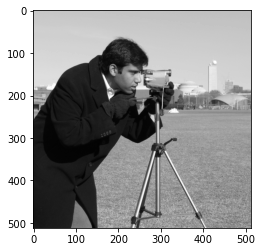

In [3]:
#############
# Load image
#############
img = skimage.data.camera().astype('f4')/255
imshow(img,cmap='gray');

In [4]:
##############################
# Define optimization problem
##############################
# Input: 
# Step 1. Define samples at x,y coordinates on a regular grid
pointgrid = np.mgrid[:img.shape[0],:img.shape[1]]/len(img)

# Set input points within range -1 to 1
# Linearize x,y points
xy = pointgrid.reshape((2,-1)).T.astype('f4')*2-1

# Define activation function
# Options: relu, gaussian, sine, other
actfunc = 'relu'
# Optional magic scaling factor for Gaussian activations as bandwidth parameter is not defined
if actfunc == 'gaussian':
  xy *= 32

# Add positonal encoding as additional input features to overcome 'spectral bias' in neural network. This lets ReLU-activated NNs learn high-frequency functions
# Options: raw_xy, sincos, randomfourierfeatures
basis_function = 'randomfourierfeatures'
xy_posenc = encodePosition(xy, basis_function)

print( "Input to neural network:" + str(xy_posenc.shape) )


######################
# Values to fit:
# Set each point to have a target output value that is its pixel intensity
y = img.reshape((-1,1))

print( "Labels to neural network:" + str(y.shape) )

Input to neural network:(262144, 2)
Labels to neural network:(262144, 1)


In [5]:
#############################
# Define activation function
#############################
if actfunc == 'relu':
    # ReLU activation
    activation = kl.ReLU
elif actfunc== 'gaussian':
    # Gaussian activation
    activation = lambda: kl.Activation(lambda x: tf.math.exp(-x*x))
elif actfunc == 'sine':
    # Sine activation
    activation = lambda: kl.Activation(tf.math.sin)
elif actfunc == 'other':
    activation = lambda: kl.Activation(lambda x: 1/(1+x*x))
else:
    raise ValueError('Unknown activation function')


####################
# Make model
####################
model = keras.Sequential([
    kl.InputLayer((xy_posenc.shape[1],)),
    kl.Dense(300),
    activation(),
    kl.Dense(300),
    activation(),
    kl.Dense(300),
    activation(),
    kl.Dense(300),
    activation(),
    kl.Dense(1),
    kl.Activation(tf.nn.sigmoid)
  ])
model.compile(loss='mse',optimizer='adam')
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               900       
                                                                 
 re_lu (ReLU)                (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 re_lu_1 (ReLU)              (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 re_lu_2 (ReLU)              (None, 300)               0         
                                         

2022-09-24 16:43:38.033868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-24 16:43:38.034012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
####################
# Fit model to data
####################
model.fit(xy_posenc, y, batch_size=1024,epochs=100);

Epoch 1/100


2022-09-24 16:43:38.208794: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-24 16:43:38.350704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


256/256 [==============================] - 2s 8ms/step - loss: 0.0181
Epoch 2/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0103
Epoch 3/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0091
Epoch 4/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0087
Epoch 5/100
256/256 [==============================] - 2s 7ms/step - loss: 0.0080
Epoch 6/100
256/256 [==============================] - 2s 7ms/step - loss: 0.0078
Epoch 7/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0076
Epoch 8/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0075
Epoch 9/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0073
Epoch 10/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0072
Epoch 11/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0070
Epoch 12/100
256/256 [==============================] - 2s 8ms/step - loss: 0.0068
Epoch 13/100
256/256 [===

In [7]:
##################################
# Make prediction given fit model
##################################

# We will make a prediction with the same number of points but with those points spread out x2 beyond the bounds of the input data.

# Remember that x,y might now be positionally-encoded features, so pass them through the PE generator.
# Further, if we want to change the size of the input domain, we need to do it to the input uv to the PE encoding.
xy_posenc = encodePosition(xy, basis_function)

# Make prediction
yhat = model.predict(xy_posenc, batch_size=8192)

2022-09-24 16:47:01.029342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


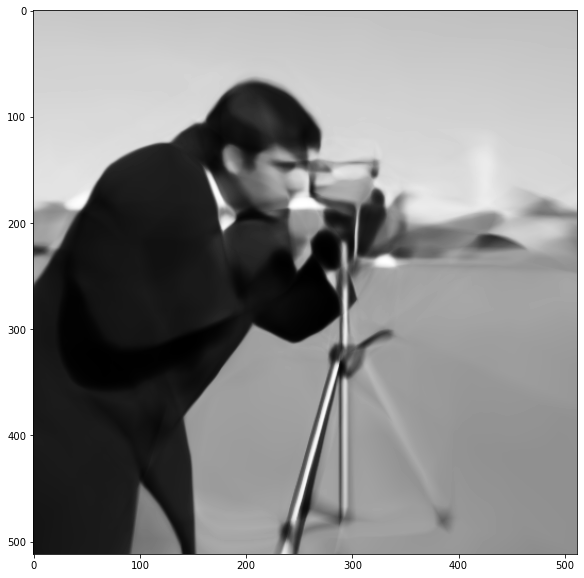

In [8]:
######################
# Plot prediction
######################
figure(figsize=(10,10))
imshow(yhat.reshape(img.shape),cmap='gray');

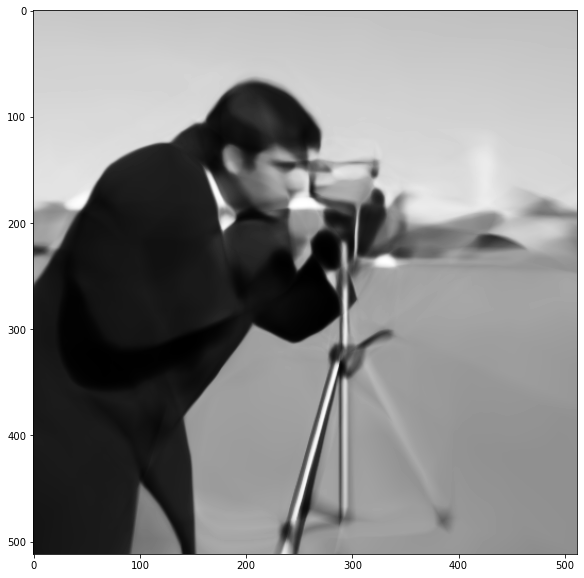

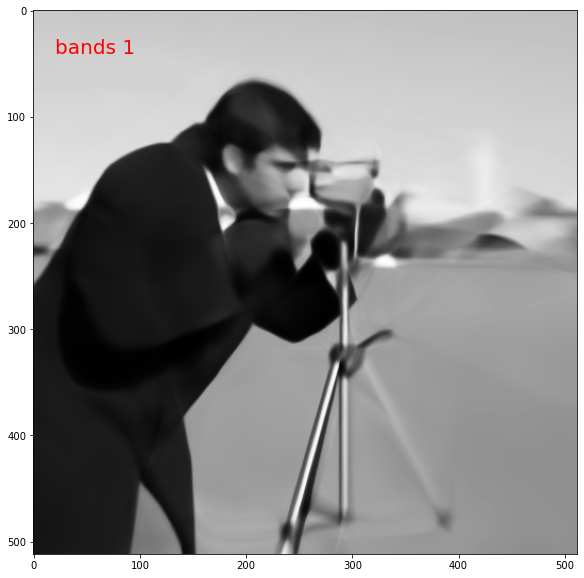

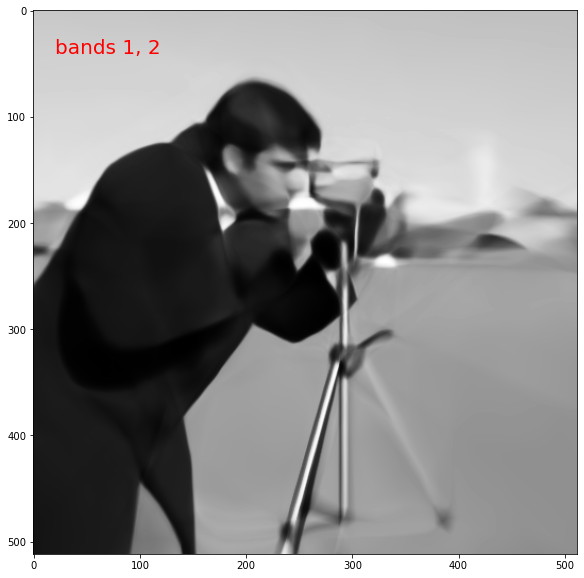

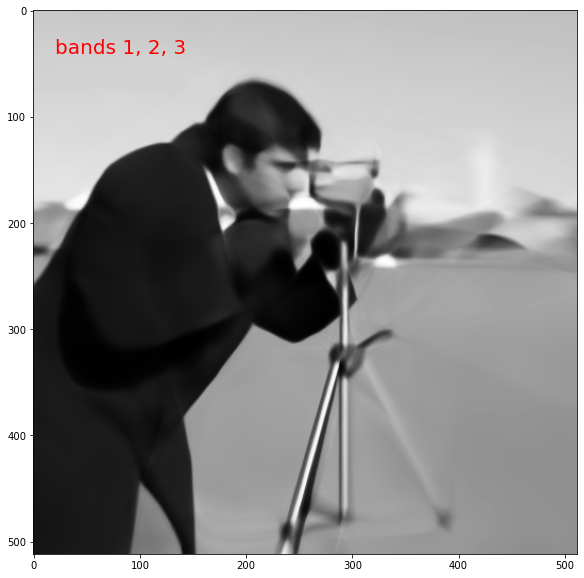

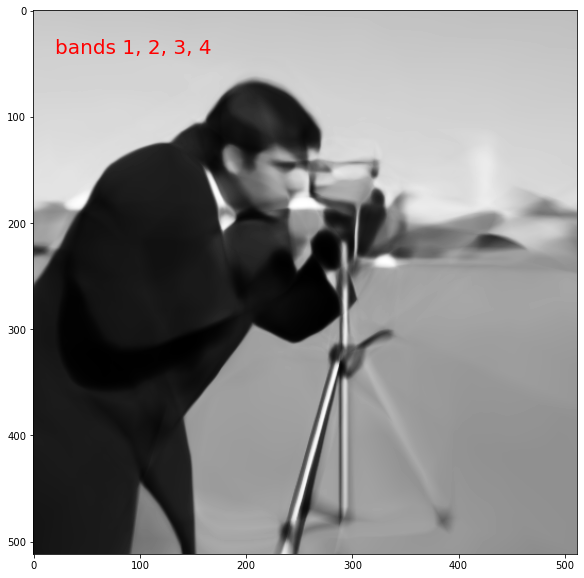

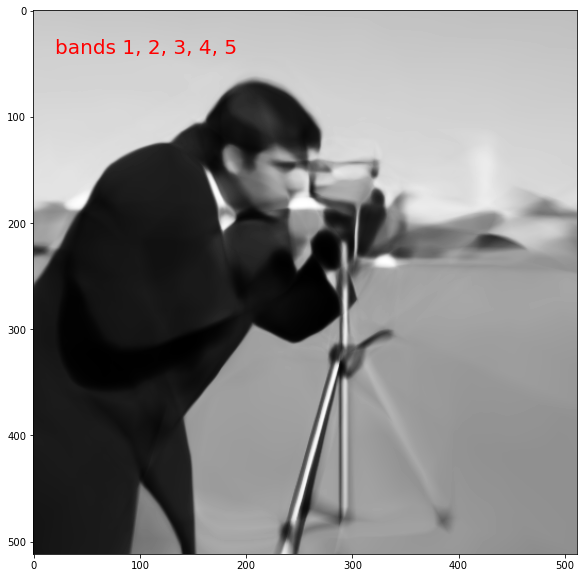

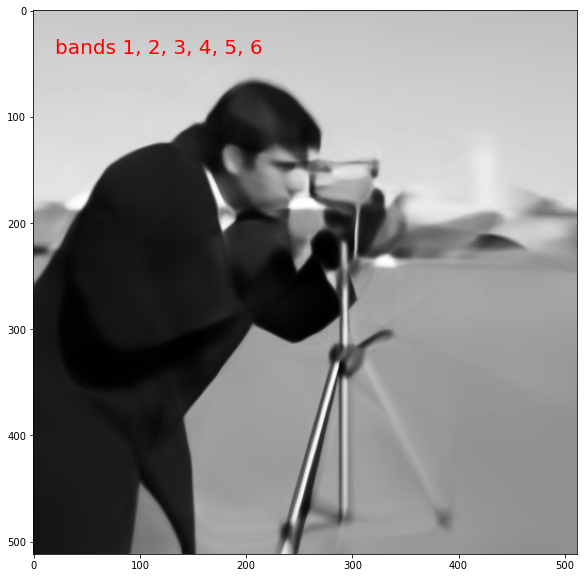

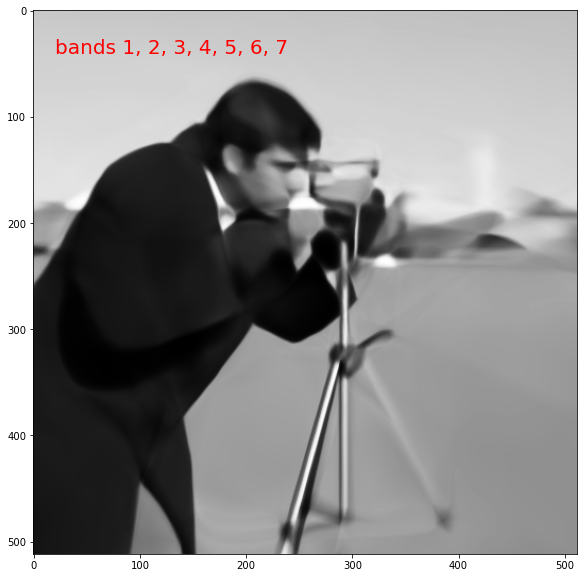

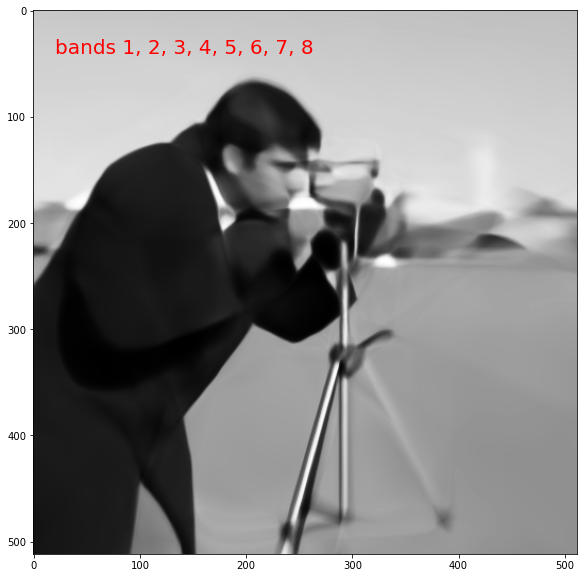

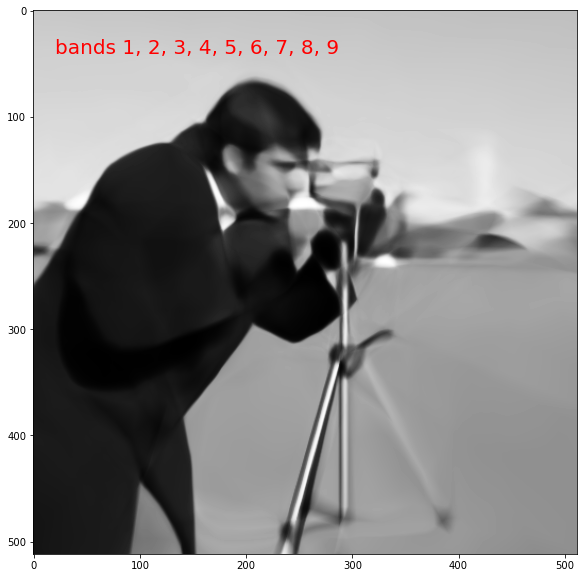

In [9]:
xy_posenc = encodePosition(xy, basis_function)
bands = [1,2,3,4,5,6,7,8,9]
for band in bands:
    xy_posenc[:, 4 * band : 4 * (band + 1)] *= 0
yhat = model.predict(xy_posenc, batch_size=8192)
figure(figsize=(10,10))
imshow(yhat.reshape(img.shape),cmap='gray');
for i in range(len(bands)):
    xy_posenc = encodePosition(xy, basis_function)
    label = 'bands '
    for band in bands[i:]:
        xy_posenc[:, 4 * band : 4 * (band + 1)] *= 0
    for band in bands[:i + 1]:
        label += str(band) + ', '
    label = label[:-2]
    yhat = model.predict(xy_posenc, batch_size=8192)
    figure(figsize=(10,10))
    imshow(yhat.reshape(img.shape),cmap='gray');
    # add large text label
    plt.text(20, 40, label, color='red', fontsize=20)
    plt.savefig('frames/frame{}.png'.format(i))




In [10]:
# make a gif
import imageio
images = []
for i in range(len(bands)):
    for j in range(10):
        images.append(imageio.imread('frames/frame{}.png'.format(i)))
imageio.mimsave(basis_function + "_pe_" + actfunc + "_act.gif", images)